# Tarea 3: Modelos de Clasificación

Integrantes:
- Fernando Mansilla
- Fernanda Mora


La detección de discursos de odio, o Hate Speech Recognition, es crucial en inteligencia artificial para fomentar un entorno en línea seguro y proteger los derechos fundamentales. Las redes sociales, debido al anonimato y alcance, son propicias para este comportamiento. Plataformas como Twitter han mostrado preocupación, pero la mayoría de los esfuerzos se centran en inglés, lo que limita su eficacia en otros idiomas, especialmente en variantes como el "Chileno" dado por sus modismos. La eliminación de este contenido es esencial para un entorno en línea más seguro y amigable.

El objetivo de este proyecto es crear una herramienta para detectar odio dentro del contenido de un tweet en español (chileno), es decir, permite detectar si el contenido de dicho tweet contiene "odio" o no, y así pudiendo eliminar estos discursos para crear un entorno más saludable.

Se tienen una base de datos incluye información de 2256 tweets escritos en "chileno" con 3 variables que será utilizada para el entrenamiento del modelo. Luego, se tiene una segunda base de datos para evaluar dicho modelo, esta contiene información de 2291 tweets con 2 variables (excluye la variable "Odio" ya que corresponde la variable a predecir).
Las 3 variables corresponden a:
* tweet_id: Un identificador numérico del Tweet (variable numérica discreta) 
* text: Contenido del Tweet como Texto libre (variable categórica)
* Odio: Número de anotadores que consideran que el Tweet contiene Odio o no (variable numérica discreta binaria)

Para la evaluación del modelo, se genera un archivo CSV con una sola variable y 2291 observaciones de Odio. Para esto, se considera el rendimiento de acuredo al F1-Score usando como clase positiva la clase Odio.





## Paso 1: Limpieza de datos y Selección de Variables

In [1]:
#Librerías requeridas:
import pandas as pd
import numpy as np
from plotnine import *
import sys
import matplotlib.pyplot as plt


In [2]:
#Visualización preliminar:
df_train = pd.read_csv("train_tweets.csv")
print(df_train.shape)  # Cantidad de entidades y atributos (filas,columnas)
df_train.head()  # Estructura del dataframe

(2256, 3)


,tweet_id,text,Odio
0,1399516036240662528,En una amistad o soy tipo: \r\nLo peor es que ...,0
1,1320788179721560065,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA...,1
2,1079889645280944129,menos mal q se recibe el año con ropa blanca j...,0
3,1369254390134145033,Cuantos INFILTRADOS extranjeros hay ahi😡 https...,1
4,1533854824378290176,#ENCONTRADO #GUAYAQUIL\r\nFecha: 06/06/22\r\nS...,0


En primer lugar, se observa que efectivamente existen información de 2256 tweets (filas) y 3 variables (columnas). 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2256 non-null   int64 
 1   text      2256 non-null   object
 2   Odio      2256 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 53.0+ KB


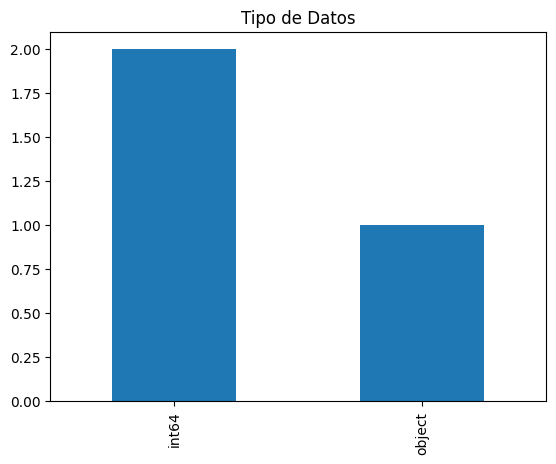

Hay 0 tweets duplicados


In [3]:
df_train.info()  # Características generales de las variables
df_train.dtypes.value_counts().plot(kind="bar", title="Tipo de Datos")
plt.show()

duplicate_tweets = df_train[df_train.duplicated(['text'])]
print(f"Hay {duplicate_tweets.shape[0]} tweets duplicados")

Se observa que no existen datos faltantes en la base de datos y que el tipo de variable definida anteriormente para cada variable es correcta. Además no se observan datos duplicados. Por lo tanto, sólo se elimina la variable "tweet_id" ya que no entrega información relevante acerca de los datos, y se mantienen las 2256 observaciones para el entrenamiento del modelo.


Text(0.75, 2000, 'Tweets No Odio: 954')

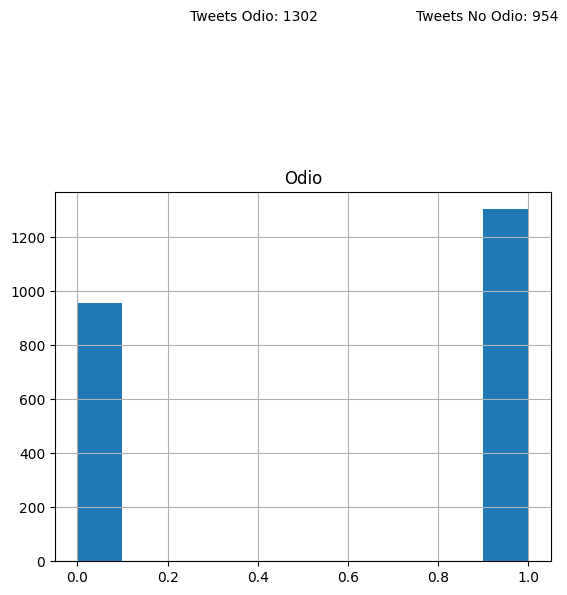

In [4]:
df_train = df_train.drop(columns= ["tweet_id"])
df_train[["Odio"]].hist()

odio_count = df_train[df_train['Odio'] == 1].shape[0] 
no_odio_count = df_train[df_train['Odio'] == 0].shape[0]

plt.text(0.25, 2000, f"Tweets Odio: {odio_count}")  
plt.text(0.75, 2000, f"Tweets No Odio: {no_odio_count}")

Por último, se observa que el 57,71% de los tweets almacenados en la base de datos corresponden a mensajes de odio.

## Paso 2: Búsqueda de hiperparámetros y aplicación de SVM para los datos 

In [5]:
#Librerías requeridas:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import re

#Conjunto de prueba
df_test = pd.read_csv("test_tweets.csv")

#Variable independiente X y variable respuesta Y del conjunto de entrenamiento
X_train = df_train['text']  
y_train = df_train['Odio']

#Variable independiente X del conjunto de prueba
X_test = df_test['text']  

Luego de cargar las librerías requeridas, se carga el conjunto de prueba test_tweets.csv que como se mencionó anteriormente, contiene 2291 observaciones. Se definen las variables X_train que contiene la variable de los tweets e Y_train que contiene la variable numérica que define si el tweet es de odio o no. Además se define la variable X_test correspondiente al set de datos de prueba.

In [6]:
#Librerías requeridas
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Vectorizar solo train
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['text']) 
y_train = df_train['Odio']

#GridSearch para hiperparámetros con SVM
params = {'C': [0.1, 1, 1.5, 2], 'gamma': [0.01, 0.1, 0.5,1],'degree': [1,2,3], 'kernel': ['rbf','linear','poly','sigmoid']}
gridsearch = GridSearchCV(SVC(), params, cv=5,scoring='f1')
gridsearch.fit(X_train, y_train)

#Vectorizar test_tweets
X_test = vectorizer.transform(df_test['text']) 

print("Mejores parametros:", gridsearch.best_params_)
print("Best F1 Score:", gridsearch.best_score_)

#Modelo SVM Optimizado
best_svm = gridsearch.best_estimator_



Mejores parametros: {'C': 1.5, 'degree': 1, 'gamma': 0.5, 'kernel': 'sigmoid'}
Best F1 Score: 0.7963748151022922


Primero, se vectorizan los textos del conjunto de entrenamiento usando TF-IDF a través de TfidfVectorizer. Esto genera una representación numérica de los textos requerida por los modelos de machine learning. Solo se transforma el train para no filtrar información al test set. Posteriormente, se definen los hiperparámetros y sus valores candidatos para SVM en el diccionario params. Luego se realiza una búsqueda de la mejor configuración mediante validación cruzada con GridSearchCV.

Se vectorizan los tweets del conjunto de prueba con el mismo vectorizer entrenado en el train set. Así se obtienen features compatibles con el modelo para realizar las predicciones sobre el set de prueba con el mejor modelo SVM encontrado.

Finalmente con los hiperparámetros óptimos para el modelo SVM (c=1.5, gamma=0.5, kernel= sigmoide) se obtiene un F1 score de 0.7964. La métrica de rendimiento F1-score es una medida que combina la precisión (precision) y la exhaustividad (recall) en una sola medida, proporcionando una visión más equilibrada del rendimiento del modelo. Entonces, un F1-score cercano a 0 indica un rendimiento muy pobre mientras que 1 indica un rendimiento perfecto. Por lo tanto, se podría decir que es rendimiento es del modelo es bueno (casi un 80%).


## Paso 3: Búsqueda de hiperparámetros y aplicación de Naive Bayes para los datos 

In [7]:
#Librerías requeridas
from sklearn.naive_bayes import MultinomialNB

#Hiperparámetros
params = {
    'alpha': [0.1, 1.0, 10.0]
}

#Grid Search para hiperparámetros con Naive Bayes
grid_nb = GridSearchCV(MultinomialNB(), params, cv=5, scoring='f1')  
grid_nb.fit(X_train, y_train)

print("Mejores Parámetros NB:", grid_nb.best_params_)
print("Best F1 Score NB:", grid_nb.best_score_)

#Modelo NB Optimizado
best_nb = grid_nb.best_estimator_



Mejores Parámetros NB: {'alpha': 0.1}
Best F1 Score NB: 0.7935882651538211


Específicamente, se define un grid de valores candidatos para el hiperparámetro alpha. Luego, al igual que en el modelo anterior, se realiza una validación cruzada de 5 folds barajando distintas combinaciones de dichos valores, para encontrar cuál maximiza el puntaje F1 en la detección de odio.
El mejor modelo resultante se almacena en best_nb.

Se obtiene como hiperparámetro óptimo alpha= 0.1 para el modelo Naive Bayes, con el cual se obtiene un F1-score de 0.7936, una disminución del rendimiento despereciable con respecto al modelo SVM. Nuevamente, se puede decir que, el modelo tiene un buen rendimiento para predecir.

## Paso 4: Búsqueda de hiperparámetros y aplicación de Ensamblado para los datos 

In [9]:
#Librerías requeridas:
from sklearn.ensemble import RandomForestClassifier

#Crear modelo
rf_model = RandomForestClassifier()

#Hiperparámetros
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 8, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

#GridSearch para hiperparámetros con Random Forest 
rf_gs = GridSearchCV(rf_model, params, cv=5, scoring='f1')
rf_gs.fit(X_train, y_train)

print("Mejores parametros RF:", rf_gs.best_params_)
print("Mejor F1 RF:", rf_gs.best_score_)

#Modelo RF Optimizado
best_rf = rf_gs.best_estimator_

/Users/fernandamoramunoz/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fernandamoramunoz/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fernandamoramunoz/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/fernandamoramunoz/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 63

Mejores parametros RF: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mejor F1 RF: 0.7943555479415824


Se inicializa un modelo de Random Forest y se definen los rangos de valores candidatos para los hiperparámetros a optimizar. Se realiza una validación cruzada de 5 folds utilizando la métrica F1 score como función de evaluación, para encontrar la combinación de hiperparámetros que maximicen la capacidad de detección de odio del modelo Random Forest. El error de esta parte del código ocurre dado a una equivocación cometida en max_features donde no se debió proporcionar 'auto' como valor de prueba.

Se obtiene como hiperparámetros óptimos del Modelo de Ensamblado Random Forest son criterion = entropy, n_estimators= 200, max_features=log2, min_saples_leaf=1, min_samles_split=5 y max_depth = None con los cuales el F1 es 0,7944. Este modelo presenta un rendimiento menor al modelo SVM, pero más alto que el modelo Naive Bayes, sin embargo, las diferencias siguen siendo despreciables y presenta un buen desempeño.

## Paso 4: Comparación y Selección del Mejor Modelo

Comparando los modelos implementados y sus respectivos rendimientos de acuerdo al F1-score:

* El modelo SVM logra el mayor puntaje de F1 (0.7964) utilizando los hiperparámetros óptimos encontrados mediante Grid Search Cross Validation. 
* Le sigue muy de cerca el modelo Ensamblado Random Forest con 0.7946 de F1, con una pequeña diferencia en performance.
* Finalmente, el modelo Naive Bayes alcanza un 0.7936 de F1, aún un buen valor pero inferior que los anteriores.

Considerando estos resultados, se selecciona el modelo SVM como el algoritmo con mejor capacidad de generalización y métricas en la detección de discursos de odio en este problema. Si bien la diferencia de F1 con Random Forest es mínima (0.0018), SVM presenta una pequeña ventaja, logrando casi un 80% de exactitud combinando precisión y exhaustividad.


In [10]:
y_pred = best_svm.predict(X_test)
tweet_id = df_test['tweet_id']
predictions_svm_df = pd.DataFrame({"tweet_id":tweet_id, "Odio": y_pred})
predictions_svm_df.to_csv("predictions_svm.csv", index=False)